In [73]:
# basics
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow import keras
from tensorflow.keras import optimizers


# CNN pre created models
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG19

# Buid NN model 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout

# image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# load models
from tensorflow.keras.models import load_model

# scores
from sklearn.metrics import roc_auc_score, matthews_corrcoef, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', 200)

# Collab
from google.colab import drive
drive.mount('/content/drive')
# base_path = "/content/drive/MyDrive/MAIA/S2/machine_learning/project/alzheimer/"
base_path = "/content/drive/MyDrive/S2/machine_learning/project/alzheimer/" # mica path

# GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# base_path = ""
tasks_numbers = [1, 2, 3, 4, 9, 10]
metrics = ["acc", "sen", "spe", "pre", "f1", "auc", "mcc", "ba"]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h2>Functions</h2>

In [74]:
# access to the folders
def str2int_padded(img_nb, nb_zeros = 2):
    min_not_pad = 10**(nb_zeros-1)
    if img_nb<min_not_pad:
        img_nb = str(img_nb).zfill(nb_zeros)
    else:
        img_nb = str(img_nb)
    return img_nb
    
def get_path(task=1, folder = "images"):
    if task not in tasks_numbers:
        raise ValueError('Task not well selected, choose one among:', tasks_numbers)

    prefix = base_path + folder + '/TASK'
    path = prefix + str2int_padded(task)

    return path

def __get_trained_modles_path(task_number):
   return base_path + "models/TASK" + str2int_padded(task_number) + "/"

def __create_base_name_to_save(dnn_name, epochs, not_frozen_layers, batch_size, optimizer_type):
   return dnn_name + "_imagenet_epochs=" + str(epochs) + "_nfl=" + str(not_frozen_layers) +  "_batch=" + str(batch_size) +  "_optimizer=" + optimizer_type

def get_model_path(task_number):
   return __get_trained_modles_path(task_number) + "models/" 

def get_model_path_name(task_number, dnn_name, epochs, not_frozen_layers, batch_size, optimizer_type):
   return get_model_path(task_number) + __create_base_name_to_save(dnn_name, epochs, not_frozen_layers, batch_size, optimizer_type) + ".h5"

def get_history_path_name(task_number, dnn_name, epochs, not_frozen_layers, batch_size, optimizer_type):
   return __get_trained_modles_path(task_number) + "histories/" + __create_base_name_to_save(dnn_name, epochs, not_frozen_layers, batch_size, optimizer_type) + ".csv"

def get_retrained_model_path(task_number):
   return __get_trained_modles_path(task_number) + "best_models/" 
   
def get_retrained_model_path_name(task_number, dnn_name, epochs, not_frozen_layers, batch_size, optimizer_type):
   return get_retrained_model_path(task_number) + __create_base_name_to_save(dnn_name, epochs, not_frozen_layers, batch_size, optimizer_type) + ".h5"

def get_final_model_path(task_number):
   return __get_trained_modles_path(task_number) + "final_models/" 

def get_final_model_path_name(task_number,  dnn_name, epochs, not_frozen_layers, batch_size, optimizer_type):
   return get_final_model_path(task_number) + __create_base_name_to_save(dnn_name, epochs, not_frozen_layers, batch_size, optimizer_type) + ".h5"
   
def get_retrained_history_path(task_number):
   return __get_trained_modles_path(task_number) + "best_histories/"
  
def get_retrained_history_path_name(task_number, dnn_name, epochs, not_frozen_layers, batch_size, optimizer_type):
   return get_retrained_history_path(task_number) + __create_base_name_to_save(dnn_name, epochs, not_frozen_layers, batch_size, optimizer_type) + ".csv"
  
def get_final_history_path(task_number):
   return __get_trained_modles_path(task_number) + "final_histories/"
  
def get_final_history_path_name(task_number, dnn_name, epochs, not_frozen_layers, batch_size, optimizer_type):
   return get_final_history_path(task_number) + __create_base_name_to_save(dnn_name, epochs, not_frozen_layers, batch_size, optimizer_type) + ".csv"
  
def get_results_path(task_number):
  return __get_trained_modles_path(task_number) + "results/results.csv"

# datasets loaders
def get_dataset_flow_train_eval(task, batch_size):
    data_dir = get_path(task=task, folder="images_sep")
    input_shape = (299, 299, 3)

    data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255,)

    train_data = data_augmentation.flow_from_directory(
      directory=data_dir + "/train",
      target_size=input_shape[:2],
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True)

    val_data = data_augmentation.flow_from_directory(
      directory=data_dir + "/eval",
      target_size=input_shape[:2],
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True)
    
    return train_data, val_data

def get_dataset_eval(task, batch_size):
    data_dir = get_path(task=task, folder="images_sep")
    input_shape = (299, 299, 3)

    data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255,)
    
    val_data = data_augmentation.flow_from_directory(
      directory=data_dir + "/eval",
      target_size=input_shape[:2],
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=False)
    
    return val_data

# check data (visualize images)
def flow2np(dataset):
    features_list = []
    labels_list = []

    for _ in range(len(dataset)):
        features, labels = next(dataset)
        features_list.append(features)
        labels_list.append(labels)

    features_list = np.concatenate(features_list)
    labels_list = np.concatenate(labels_list)[:, 0]
    return features_list, labels_list

def visualize_imgs(data, labels=None):
    # Crear una cuadrícula de imágenes a partir del lote
    num_images = data.shape[0]
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    # Crear la figura y los ejes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))
    axes = axes.flatten()

    for i in range(num_images):
        image = data[i, :, :, 0]  # Obtener la imagen (suponiendo canales en la última dimensión)
        axes[i].imshow(image, cmap='gray')
        # axes[i].axis('off')

        if labels is not None:
            axes[i].set_title(str(labels[i]))  # Agregar el título con la etiqueta

    # Eliminar los ejes vacíos si es necesario
    if num_images < num_rows * num_cols:
        for i in range(num_images, num_rows * num_cols):
            axes[i].remove()

    plt.tight_layout()
    plt.show()

def check_data(data, labels = None, nb_imgs_to_show=1):
    print (f"\n%d Images of %d x %d x %d"%data.shape)
    mean = data.mean()
    std = data.std()
    print("mean: ", mean, "\tstd: ", std)
    # visual check
    if nb_imgs_to_show > 1:
        imgs_to_visualize = data[:nb_imgs_to_show, :, :, :]
        if labels is not None:
            labels = labels[:nb_imgs_to_show]
        visualize_imgs(imgs_to_visualize, labels)

# DNN functions
def get_end_net(basic_net, end_model=3):
    if end_model == 1:
        x = basic_net.output #(None, None, None, 2048)
        x = GlobalAveragePooling2D()(x) # (None, 2048) 
        x = Dense(200, activation='relu')(x) 
        predictions = Dense(2, activation='sigmoid')(x)
        return predictions

    elif end_model == 2:
        x = basic_net.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        predictions = Dense(2, activation='sigmoid')(x)
        return predictions

    if end_model == 3: # used end layer
        x = basic_net.output #(None, None, None, 2048)
        x = GlobalAveragePooling2D()(x) # (None, 2048) 
        x = Dense(256, activation='relu')(x) 
        x = Dropout(0.5)(x)
        predictions = Dense(2, activation='softmax')(x)
        return predictions

    elif end_model == 4:
        models = keras.models.Sequential()
        models.add(basic_net)
        models.add(GlobalAveragePooling2D())
        models.add(Dense(256, activation='relu'))
        models.add(Dropout(0.5))
        models.add(Dense(2, activation='softmax'))  
        return models

def frozen_layers(base_model, not_frozen_layers=0):
    if not_frozen_layers < 0:
        max = 0
    else:
        max = len(base_model.layers) -not_frozen_layers
        
    for i in range(len(base_model.layers)):
        if i == max:
            break 
        base_model.layers[i].trainable = False

def fine_tunning(base_model, trainset_flow, validationset_flow = None, batch_size=10, epochs=10, not_frozen_layers=0, optimizer_type="adam"):
    frozen_layers(base_model, not_frozen_layers=not_frozen_layers)
    predictions = get_end_net(base_model)

    model = Model(inputs=base_model.input, outputs=predictions)

    if optimizer_type == "paper":
      optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
    elif optimizer_type == "adam":
      optimizer = "adam"
    else:
       print("OPTIMIZADOR NO VALIDO")

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')
    if validationset_flow == None:
      history = model.fit(trainset_flow, 
                steps_per_epoch=trainset_flow.n // batch_size, 
                epochs=epochs)
    else:
      history = model.fit(trainset_flow, 
                steps_per_epoch = trainset_flow.n // batch_size, 
                epochs=epochs, 
                validation_data = validationset_flow,
                validation_steps = validationset_flow.n // batch_size)
    return model, history

# scores functions
def compute_scores(y, y_pred, y_pred_probability):
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
  acc = (tp+tn)/(tn + fp + fn + tp)
  spec = tn / (tn + fp)
  sens = tp / (tp + fn)
  prec  = tp/(tp+fp)  
  f1 = (2 * prec * sens)/(prec + sens)
  ba = (spec + sens)/2
  mcc = matthews_corrcoef(y, y_pred)
  auc = roc_auc_score(y, y_pred_probability)
  
  return {"tn":tn, "fp":fp, "fn":fn, "tp":fn, "acc":acc, "spe":spec, "sen":sens, "pre":prec, "f1":f1, "ba":ba, "auc":auc, "mcc":mcc}


def test_prediction(model, dataset_flow, model_name = None):
  true_labels = dataset_flow.classes
  predictions = model.predict(dataset_flow)
  predicted_labels = np.argmax(predictions, axis=1)
  res = compute_scores(true_labels, predicted_labels, predictions[:, 1])
  if model_name is not None:
    columns = ["model"] + metrics
    table =  pd.DataFrame(columns=columns)
    table = table.append(pd.Series([ model_name, res["acc"], res["sen"], res["spe"], res["pre"], res["f1"], res["auc"], res["mcc"], res["ba"]], index=columns),
                              ignore_index=True)
    print(table.head())
    
  return res

def save_history(history, path_name):
  loss_train = history.history['loss']
  accuracy_train = history.history['accuracy']

  loss_val = history.history['val_loss']
  accuracy_val = history.history['val_accuracy']

  history_df = pd.DataFrame({'train_loss': loss_train,
                            'train_acc': accuracy_train,
                            'val_loss': loss_val,
                            'val_acc': accuracy_val})

  history_df.to_csv(path_name, index=False)



<h2> Step 1: Find best models </h2>

<h3>Handmade grid search</h3>




Parameters

In [75]:
# basics
batch_size = 4
epochs = 10
input_shape = (299, 299, 3)

# grid search
dnn_names = ["resnet50", "inceptionResnetV2", "inceptionV3",  "vgg19"]
gs_optimizer_type = ["paper", "adam"]
gs_not_frozen_layers = [0, 1, 2, 3]

Grid search

In [76]:

def create_models(tasks = []):
    # grid search on all the tasks
    for task_number in tasks:
        trainset_flow, validationset_flow = get_dataset_flow_train_eval(task=task_number,batch_size = batch_size)
        for dnn_name in dnn_names:
            for not_frozen_layers in gs_not_frozen_layers:
                for optimizer_type in gs_optimizer_type:
                    if dnn_name == dnn_names[0]:
                        base_dnn = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
                    elif dnn_name == dnn_names[1]:
                        base_dnn = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
                    elif dnn_name == dnn_names[2]:
                        base_dnn = InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape) 
                    elif dnn_name == dnn_names[3]:
                        base_dnn = VGG19(weights="imagenet", include_top=False, input_shape=input_shape) 

                    model, history = fine_tunning(base_dnn, trainset_flow, validationset_flow, batch_size=batch_size, epochs=epochs, not_frozen_layers=not_frozen_layers, optimizer_type=optimizer_type)
                    model.save(get_model_path_name(task_number, dnn_name, epochs, not_frozen_layers, batch_size=batch_size, optimizer_type=optimizer_type))
                    save_history(history, get_history_path_name(task_number, dnn_name, epochs, not_frozen_layers, batch_size=batch_size, optimizer_type=optimizer_type))

# HEAVY CODE DO NOT RUN 
# create_models(tasks_numbers)


Compute grid search results

In [77]:
def create_results_tables(tasks = []):
    columns = [ "Model", "optimizer_type", "not_frozen_layers" ] + metrics 
    for task_number in tasks:
        dataset_flow = get_dataset_eval(task_number, batch_size=batch_size)
        table =  pd.DataFrame(columns=columns)
        for dnn_name in dnn_names:
            for not_frozen_layers in gs_not_frozen_layers:
                for optimizer_type in gs_optimizer_type:

                    loaded_model = load_model(get_model_path_name(task_number, dnn_name, epochs, not_frozen_layers, batch_size=batch_size, optimizer_type=optimizer_type))
                    res = test_prediction(loaded_model, dataset_flow)
                    table = table.append(pd.Series([ dnn_name, optimizer_type, not_frozen_layers, res["acc"], res["sen"], res["spe"], res["pre"], res["f1"], res["auc"], res["mcc"], res["ba"]], index=columns),
                            ignore_index=True)

        table.to_csv(get_results_path(task_number), index=False)

# HEAVY CODE DO NOT RUN 
# create_results_tables(tasks_numbers)


<h2>Step 2: Select best model</h2>

Read grid search results to obtain the best models for each task

In [78]:
def get_best_models_table(task_number, metric= "auc", min_sen = 0.5, min_spe = 0.3):
    results = pd.read_csv(get_results_path(task_number))
    df_best_models = pd.DataFrame(columns=results.columns)
    best_2models = []

    for dnn_name in dnn_names:
        filter_model = results[(results['Model'] == dnn_name) & (results['sen'] >= min_sen ) & (results['spe'] >= min_spe )]
        if filter_model.shape[0] >= 1:
            row_index = filter_model[metric].idxmax()
            row = results.loc[row_index]
            df_best_models = df_best_models.append(row)

    df_best_models = df_best_models.sort_values(by=metric, ascending=False)

    return df_best_models

def get_2best_models(task_number, metric= "auc", model_prealoaded = False):
    best_models_table = get_best_models_table(task_number, metric)

    best_1 = best_models_table.iloc[0]
    best_2 = best_models_table.iloc[1]

    best_caracteristics_1 = {"base_dnn": best_1.iloc[0], "not_frozen_layers": best_1.iloc[2], "optimizer_type": best_1.iloc[1]}
    best_caracteristics_2 = {"base_dnn": best_2.iloc[0], "not_frozen_layers": best_2.iloc[2], "optimizer_type": best_2.iloc[1]}
    
    best_path_name_1 = get_model_path_name(task_number, best_caracteristics_1["base_dnn"], epochs, not_frozen_layers = best_caracteristics_1["not_frozen_layers"], batch_size=batch_size, optimizer_type= best_caracteristics_1["optimizer_type"])
    best_path_name_2 = get_model_path_name(task_number, best_caracteristics_2["base_dnn"], epochs, not_frozen_layers = best_caracteristics_2["not_frozen_layers"], batch_size=batch_size, optimizer_type= best_caracteristics_2["optimizer_type"])

    best_coeficient_1 = best_1.loc[metric]
    best_coeficient_2 = best_2.loc[metric]

    if model_prealoaded:
        return (best_caracteristics_1, best_path_name_1, best_coeficient_1, load_model(best_path_name_1)), (best_caracteristics_2, best_path_name_2, best_coeficient_2, load_model(best_path_name_2))
    else:
        return (best_caracteristics_1, best_path_name_1, best_coeficient_1, None), (best_caracteristics_2, best_path_name_2, best_coeficient_2, None)
    
def print_all_best_models(metric = "auc"):
    for task_number in tasks_numbers:
        print("\n--------------- TASK ", task_number, " ---------------")
        best_df = get_best_models_table(task_number, metric, min_sen = 0.4, min_spe = 0.3)
        # best_2models = get_2best_models(task_number, metric)

        print(best_df.head())
        # print(best_2models[0][2], " ", best_2models[0][1])
        # print(best_2models[1][2], " ", best_2models[1][1])

print_all_best_models()


--------------- TASK  1  ---------------
                Model optimizer_type not_frozen_layers   acc       sen       spe       pre        f1       auc       mcc        ba
29              vgg19           adam                 2  0.64  0.592593  0.695652  0.695652  0.640000  0.729469  0.288245  0.644122
22        inceptionV3          paper                 3  0.60  0.777778  0.391304  0.600000  0.677419  0.695652  0.183892  0.584541
3            resnet50           adam                 1  0.62  0.592593  0.652174  0.666667  0.627451  0.623188  0.244177  0.622383
14  inceptionResnetV2          paper                 3  0.58  0.666667  0.478261  0.600000  0.631579  0.616747  0.147442  0.572464

--------------- TASK  2  ---------------
                Model optimizer_type not_frozen_layers   acc       sen       spe       pre        f1       auc       mcc        ba
17        inceptionV3           adam                 0  0.68  0.925926  0.391304  0.641026  0.757576  0.848631  0.381673  0.658615

<h2>Step 3: Improve best models</h2>

Retrain best models with more epochs 

In [79]:
# retrain the model
def retrain_best_models(tasks_numbers, extra_epochs=20):
    def retrain_model(model, trainset_flow, validationset_flow, batch_size, epochs, optimizer_type):
        if optimizer_type == "paper":
            optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
        elif optimizer_type == "adam":
            optimizer = "adam"
        else:
            print("OPTIMIZADOR NO VALIDO")

        # binary_crossentropy
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')

        history = model.fit(trainset_flow, 
                steps_per_epoch = trainset_flow.n // batch_size, 
                epochs=epochs, 
                validation_data = validationset_flow,
                validation_steps = validationset_flow.n // batch_size)
        return model, history

    # retraining models
    fc_layers = 4
    for task_number in tasks_numbers:
        best_1, best_2  = get_2best_models(task_number, "auc", model_prealoaded=True)

        # obtaining 2 best models
        model_1 = best_1[-1]
        model_2 = best_2[-1]

        # Unfrozing just last layers
        for capa in model_1.layers:
            capa.trainable = True
        for capa in model_2.layers:
            capa.trainable = True

        frozen_layers(model_1, fc_layers + best_1[0]["not_frozen_layers"])
        frozen_layers(model_2, fc_layers + best_2[0]["not_frozen_layers"])

        trainset_flow, validationset_flow = get_dataset_flow_train_eval(task=task_number,batch_size = batch_size)

        retrained_model_1, history_model_1 = retrain_model(model_1, trainset_flow, validationset_flow, batch_size, extra_epochs, best_1[0]["optimizer_type"])
        retrained_model_1.save(get_retrained_model_path_name(task_number, best_1[0]["base_dnn"], epochs + extra_epochs, best_1[0]["not_frozen_layers"], batch_size, best_1[0]["optimizer_type"]))
        save_history(history_model_1, get_retrained_history_path_name(task_number, best_1[0]["base_dnn"], epochs + extra_epochs, best_1[0]["not_frozen_layers"], batch_size, best_1[0]["optimizer_type"]))

        retrained_model_2, history_model_2 = retrain_model(model_2, trainset_flow, validationset_flow, batch_size, extra_epochs, best_2[0]["optimizer_type"])
        retrained_model_2.save(get_retrained_model_path_name(task_number, best_2[0]["base_dnn"], epochs + extra_epochs, best_2[0]["not_frozen_layers"], batch_size, best_2[0]["optimizer_type"]))
        save_history(history_model_2, get_retrained_history_path_name(task_number, best_2[0]["base_dnn"], epochs + extra_epochs, best_2[0]["not_frozen_layers"], batch_size, best_2[0]["optimizer_type"]))

def retrain_best_models_from_scratch(tasks_numbers, epochs=1):
    for task_number in tasks_numbers:
        trainset_flow, validationset_flow = get_dataset_flow_train_eval(task=task_number,batch_size = batch_size)
        best_models = get_2best_models(task_number, "auc", model_prealoaded=True)
        for best_model in best_models:
            caracteristics  = best_model[0]

            if caracteristics["base_dnn"] == dnn_names[0]:
                base_dnn = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
            elif caracteristics["base_dnn"] == dnn_names[1]:
                base_dnn = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
            elif caracteristics["base_dnn"] == dnn_names[2]:
                base_dnn = InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape) 
            elif caracteristics["base_dnn"] == dnn_names[3]:
                base_dnn = VGG19(weights="imagenet", include_top=False, input_shape=input_shape) 

            model, history = fine_tunning(base_dnn, trainset_flow, validationset_flow, batch_size=batch_size, epochs=epochs, not_frozen_layers=caracteristics["not_frozen_layers"], optimizer_type=caracteristics["optimizer_type"])
            model.save(get_retrained_model_path_name(task_number, caracteristics["base_dnn"], epochs, caracteristics["not_frozen_layers"], batch_size, caracteristics["optimizer_type"]))
            save_history(history, get_retrained_history_path_name(task_number, caracteristics["base_dnn"], epochs, caracteristics["not_frozen_layers"], batch_size, caracteristics["optimizer_type"]))
            
# HEAVY CODE DO NOT RUN 
# retrain_best_from_scratch(tasks_numbers, epochs=1)

Select epoch with the lower validation loss and retrain models with that amout of epochs

 --------------- TASK  1  ---------------


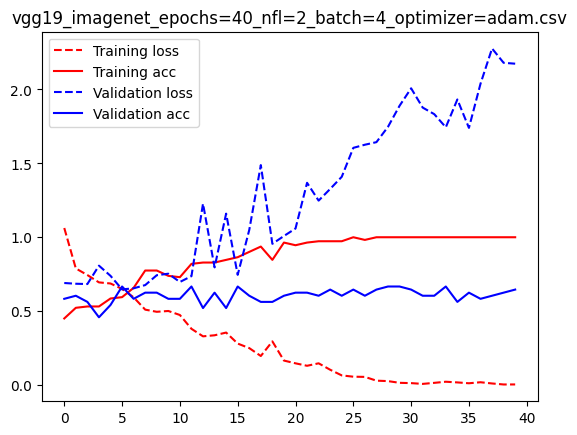

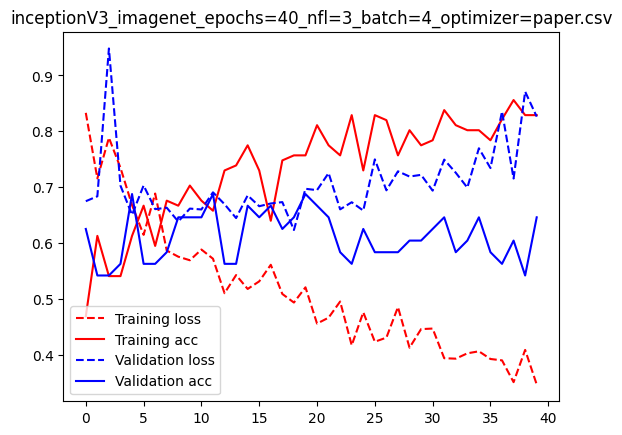

Best epoch model 1:  6
Best epoch model 2:  19
 --------------- TASK  2  ---------------


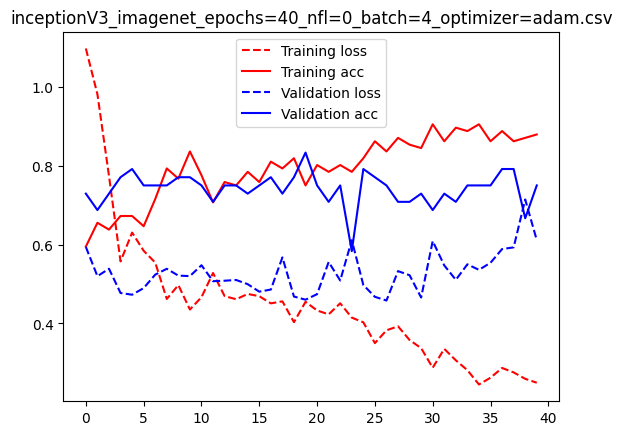

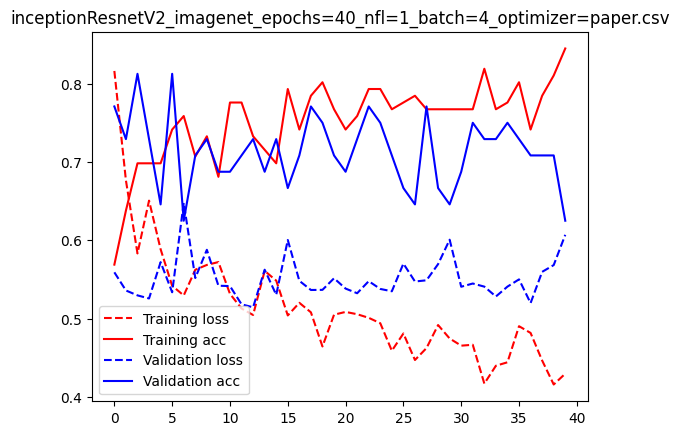

Best epoch model 1:  27
Best epoch model 2:  13
 --------------- TASK  3  ---------------


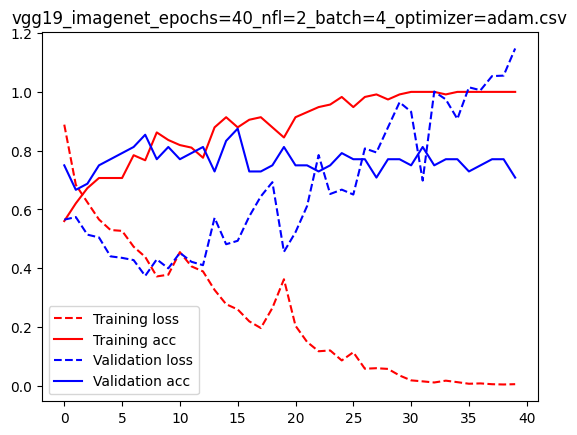

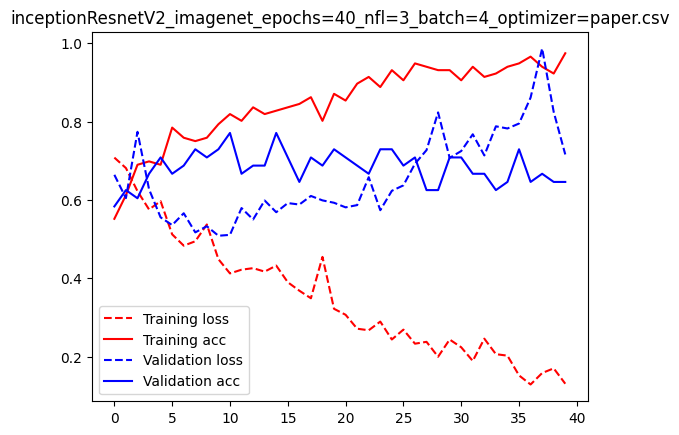

Best epoch model 1:  8
Best epoch model 2:  10
 --------------- TASK  4  ---------------


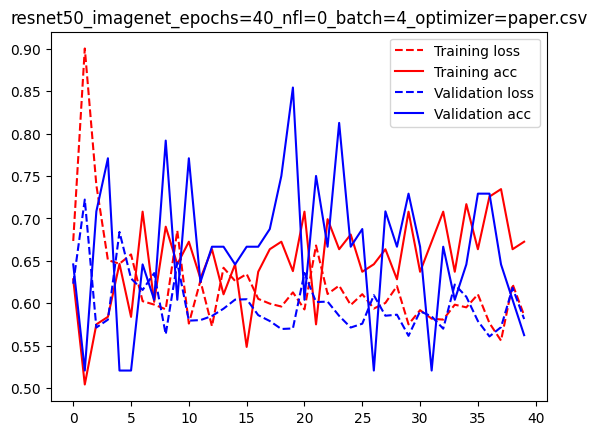

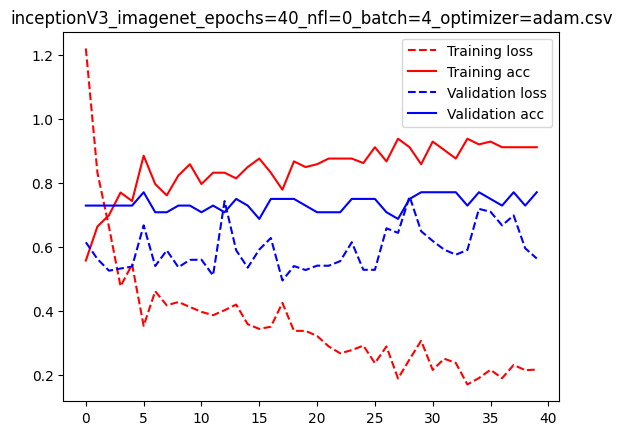

Best epoch model 1:  37
Best epoch model 2:  18
 --------------- TASK  9  ---------------


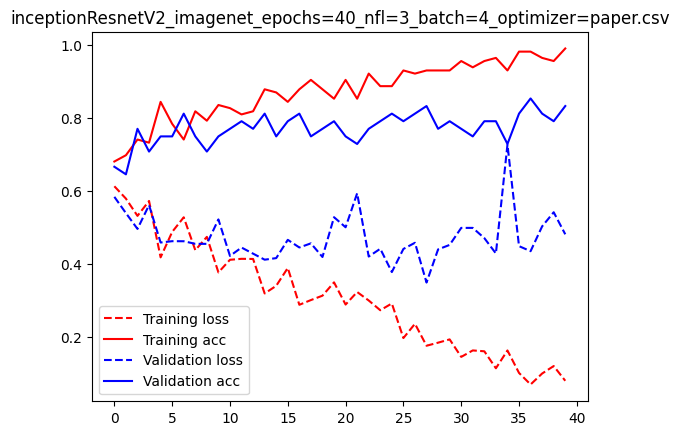

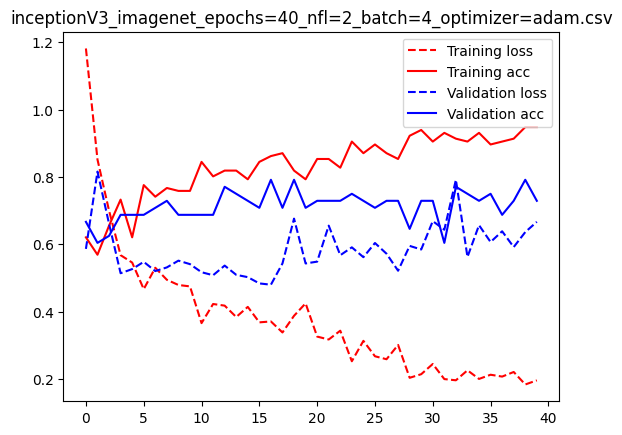

Best epoch model 1:  28
Best epoch model 2:  17
 --------------- TASK  10  ---------------


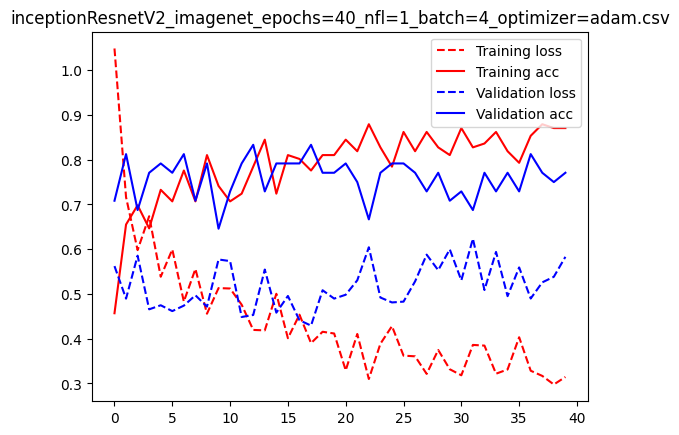

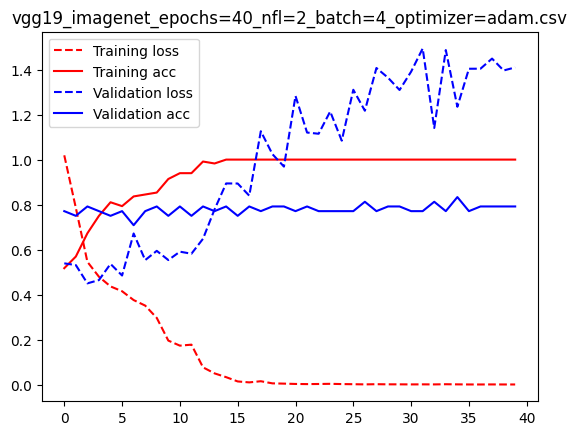

Best epoch model 1:  18
Best epoch model 2:  3


In [80]:
def show_model_epochs(model_history, model_name):
    training_loss = model_history.iloc[:, 0]
    training_acc = model_history.iloc[:, 1]
    validation_loss = model_history.iloc[:, 2]
    validation_acc = model_history.iloc[:, 3]

    x = [i for i in range(model_history.shape[0])]
    plt.plot(x, training_loss, label='Training loss', linestyle='--', color='red')
    plt.plot(x, training_acc, label='Training acc', color='red')
    plt.plot(x, validation_loss, label='Validation loss', linestyle='--', color='blue')
    plt.plot(x, validation_acc, label='Validation acc', color='blue')
    plt.title(model_name)

    # Agregar la leyenda
    plt.legend()
    plt.show()
    
def get_best_histories(task_number):
    name_history_1, name_history_2  = os.listdir(get_retrained_history_path(task_number=task_number))
    best_history_1 = pd.read_csv(get_retrained_history_path(task_number=task_number) + name_history_1)
    best_history_2 = pd.read_csv(get_retrained_history_path(task_number=task_number) + name_history_2)

    return best_history_1, best_history_2, (name_history_1, name_history_2)

def plot_best_histories(task_number):
    best_history_1, best_history_2, names = get_best_histories(task_number)
    print(" --------------- TASK ", task_number, " ---------------")
    show_model_epochs(best_history_1, names[0])
    show_model_epochs(best_history_2, names[1])

def get_model_caracteristics_from_file_name(history_name, extension_lenght = 4):
    history_name = history_name[:-extension_lenght]
    parts = (history_name.split("_"))

    base_dnn = parts[0]
    pretraned_dataset = parts[1]
    epochs = int(parts[2].split("=")[-1])
    not_frozen_layers = int(parts[3].split("=")[-1])
    batch_size = int(parts[4].split("=")[-1])
    optimizer_type = parts[5].split("=")[-1]
    return {"base_dnn":base_dnn, "pretraned_dataset":pretraned_dataset, "epochs":epochs, "not_frozen_layers":not_frozen_layers,
            "batch_size":batch_size, "optimizer_type":optimizer_type}
    

def get_final_model_caracteristics(task_number):
    best_history_1, best_history_2, names = get_best_histories(task_number)

    model_carac_1 = get_model_caracteristics_from_file_name(names[0])
    model_carac_2 = get_model_caracteristics_from_file_name(names[1])

    model_carac_1["epochs"] = best_history_1["val_loss"].idxmin() +1
    model_carac_2["epochs"] = best_history_2["val_loss"].idxmin() +1

    return model_carac_1, model_carac_2

def plots_bests_histories():
    for task_number in tasks_numbers:
        plot_best_histories(task_number=task_number)
        model_1, model_2 = get_final_model_caracteristics(task_number)
        print("Best epoch model 1: ", model_1["epochs"])
        print("Best epoch model 2: ", model_2["epochs"])


plots_bests_histories()

Retrain final models

In [81]:
def retrain_final_mdels():
    for task_number in tasks_numbers:
        trainset_flow, validationset_flow = get_dataset_flow_train_eval(task=task_number,batch_size = batch_size)
        best_models = get_final_model_caracteristics(task_number)

        for best_model_carac in best_models:
          print(best_model_carac)

          if best_model_carac["base_dnn"] == dnn_names[0]:
              base_dnn = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
          elif best_model_carac["base_dnn"] == dnn_names[1]:
              base_dnn = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
          elif best_model_carac["base_dnn"] == dnn_names[2]:
              base_dnn = InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape) 
          elif best_model_carac["base_dnn"] == dnn_names[3]:
              base_dnn = VGG19(weights="imagenet", include_top=False, input_shape=input_shape) 

          epochs = best_model_carac["epochs"]
          model, history = fine_tunning(base_dnn, trainset_flow, validationset_flow, batch_size=best_model_carac["batch_size"], epochs=epochs, not_frozen_layers=best_model_carac["not_frozen_layers"], optimizer_type=best_model_carac["optimizer_type"])
          model.save(get_final_model_path_name(task_number, best_model_carac["base_dnn"], epochs, best_model_carac["not_frozen_layers"], best_model_carac["batch_size"], best_model_carac["optimizer_type"]))
          save_history(history, get_final_history_path_name(task_number, best_model_carac["base_dnn"], epochs, best_model_carac["not_frozen_layers"], best_model_carac["batch_size"], best_model_carac["optimizer_type"]))

# HEAVY CODE DO NOT RUN 
# retrain_final_mdels()

Evaluate retrained models

In [82]:
def eval_final_models():
    for task_number in tasks_numbers:
        print(" --------------- TASK ", task_number, " ---------------")
        dataset_flow = get_dataset_eval(task=task_number, batch_size=batch_size)
        name_model_1, name_model_2  = os.listdir(get_final_model_path(task_number=task_number))

        model_1 = load_model(get_final_model_path(task_number) + name_model_1)
        res = test_prediction(model_1, dataset_flow, model_name = "model_1")

        model_2 = load_model(get_final_model_path(task_number) + name_model_2)
        res = test_prediction(model_2, dataset_flow, model_name = "model_2")

# eval_final_models()

<h2>Step 4: Ensemble learning</h2>

In [83]:
def combine_predictions(probabilities, weights):
    weights_sum = sum(weights)
    normalized_weights = np.array([[weight / weights_sum for weight in weights]]).T
    ensemble_probabilities = np.dot(np.array(probabilities).T, normalized_weights)
    y_predicted = np.where(ensemble_probabilities > 0.5, 1, 0)
    
    return y_predicted, ensemble_probabilities

def ensemble_prediction(model_1, model_2, wight_1, wight_2, dataset_flow):
    predictions_model_1 = model_1.predict(dataset_flow)[:, 1]
    predictions_model_2 = model_2.predict(dataset_flow)[:, 1]

    predictions = np.column_stack((predictions_model_1, predictions_model_2)).T
    predicted_labels, probabilities = combine_predictions(predictions, [wight_1,wight_2])
    res = compute_scores(dataset_flow.classes, predicted_labels, probabilities)
    return res

def get_ordered_models(task_number, model_version="final"):
    arg_model_1, arg_model_2 = get_2best_models(task_number, "auc", model_prealoaded=False)
    if model_version == "initial": 
      file_names = os.listdir(get_model_path(task_number=task_number))
    elif model_version == "final": 
      file_names = os.listdir(get_final_model_path(task_number=task_number))
    elif model_version == "retrained": 
      file_names = os.listdir(get_retrained_model_path(task_number=task_number))
    else:
      return None

    if file_names[0].startswith(arg_model_1[0]["base_dnn"]):
      name_model_1 = file_names[0]
      name_model_2 = file_names[1]
    else:
      name_model_1 = file_names[1]
      name_model_2 = file_names[0]

    if model_version == "initial":
      model_1 = load_model(get_model_path(task_number) + name_model_1)
      model_2 = load_model(get_model_path(task_number) + name_model_2)

    elif model_version == "final":
      model_1 = load_model(get_final_model_path(task_number) + name_model_1)
      model_2 = load_model(get_final_model_path(task_number) + name_model_2)

    elif model_version == "retrained":
      model_1 = load_model(get_retrained_model_path(task_number) + name_model_1)
      model_2 = load_model(get_retrained_model_path(task_number) + name_model_2)

    # return (model_1, coeficient_1, base_dnn_1), (model_2, coeficient_2, base_dnn_2)
    return (model_1, arg_model_1[2], arg_model_1[0]["base_dnn"]), (model_2, arg_model_2[2], arg_model_2[0]["base_dnn"])

def predict_with(task_number, model_version="final", method="ensemble"):
    dataset_flow = get_dataset_eval(task=task_number, batch_size=batch_size)

    arg_model_1, arg_model_2 = get_ordered_models(task_number, model_version)
    model_1, coef_1, base_dnn_1 = arg_model_1
    model_2, coef_2, base_dnn_2 = arg_model_2

    if method == "ensemble":
      res = ensemble_prediction(model_1, model_2, coef_1, coef_2, dataset_flow)
      model_name = base_dnn_1 + " + " +base_dnn_2
    else:
      res = test_prediction(model_1, dataset_flow)
      model_name = base_dnn_1
    return res, model_name


def make_prediction_tables(model_version="final", method="ensemble"):
    columns = ["task", "model"] + metrics
    table =  pd.DataFrame(columns=columns)
    for task_number in tasks_numbers:
        res, model_name = predict_with(task_number, model_version, method)

        table = table.append(pd.Series([ task_number, model_name, res["acc"], res["sen"], res["spe"], res["pre"], res["f1"], res["auc"], res["mcc"], res["ba"]], index=columns),
                          ignore_index=True)
    print(table.head(6))
    table.to_csv(base_path + "models/results_model_"+model_version +"_"+method+".csv", index=False)

def create_resutls_tables():
  make_prediction_tables(model_version="initial")
  make_prediction_tables(model_version="final")
  make_prediction_tables(model_version="retrained")

  make_prediction_tables(model_version="initial", method="best")
  make_prediction_tables(model_version="final", method="best")
  make_prediction_tables(model_version="retrained", method="best")

# create_resutls_tables()

<h2>Step 5: Select Final models</h2>

In [84]:
def select_best_models():
  results_model_initial_ensemble = pd.read_csv(base_path + "models/results_model_initial_ensemble.csv")
  results_model_final_ensemble = pd.read_csv(base_path + "models/results_model_final_ensemble.csv")
  results_model_retrained_ensemble = pd.read_csv(base_path + "models/results_model_retrained_ensemble.csv")

  results_model_initial_best = pd.read_csv(base_path + "models/results_model_initial_best.csv")
  results_model_final_best = pd.read_csv(base_path + "models/results_model_final_best.csv")
  results_model_retrained_best = pd.read_csv(base_path + "models/results_model_retrained_best.csv")

  results_model_initial_ensemble["model_version"] = "initial_ensemble"
  results_model_final_ensemble["model_version"] = "final_ensemble"
  results_model_retrained_ensemble["model_version"] = "retrained_ensemble"

  results_model_initial_best["model_version"] = "initial_best"
  results_model_final_best["model_version"] = "final_best"
  results_model_retrained_best["model_version"] = "retrained_best"

  results_combined = pd.concat([results_model_initial_ensemble,
                              results_model_final_ensemble,
                              results_model_retrained_ensemble,
                              results_model_initial_best,
                              results_model_final_best,
                              results_model_retrained_best],
                              ignore_index=True)

  best_results = pd.DataFrame(columns=results_combined.columns)
  metric = "auc"
  for task_number in tasks_numbers:
    
    filter_model = results_combined[results_combined['task'] == task_number]
    row_index = filter_model[metric].idxmax()
    row = results_combined.loc[row_index]
    best_results = best_results.append(row)

  print(best_results.head(6))
  # best_results.to_csv(base_path + "models/results.csv", index=False)

select_best_models()

   task                            model       acc       sen       spe       pre        f1       auc       mcc        ba     model_version
0     1              vgg19 + inceptionV3  0.620000  0.666667  0.565217  0.642857  0.654545  0.734300  0.232823  0.615942  initial_ensemble
1     2  inceptionV3 + inceptionResnetV2  0.720000  0.888889  0.521739  0.685714  0.774194  0.858293  0.446596  0.705314  initial_ensemble
26    3                            vgg19  0.800000  0.777778  0.826087  0.840000  0.807692  0.904992  0.601929  0.801932        final_best
21    4                         resnet50  0.770833  0.600000  0.956522  0.937500  0.731707  0.900870  0.589768  0.778261      initial_best
34    9                inceptionResnetV2  0.840000  0.814815  0.869565  0.880000  0.846154  0.895330  0.682187  0.842190    retrained_best
23   10                inceptionResnetV2  0.840000  0.814815  0.869565  0.880000  0.846154  0.895330  0.682187  0.842190      initial_best


<h2>Plots</h2>

Unforzen layers vs accuracy

 --------------- TASK  1  ---------------


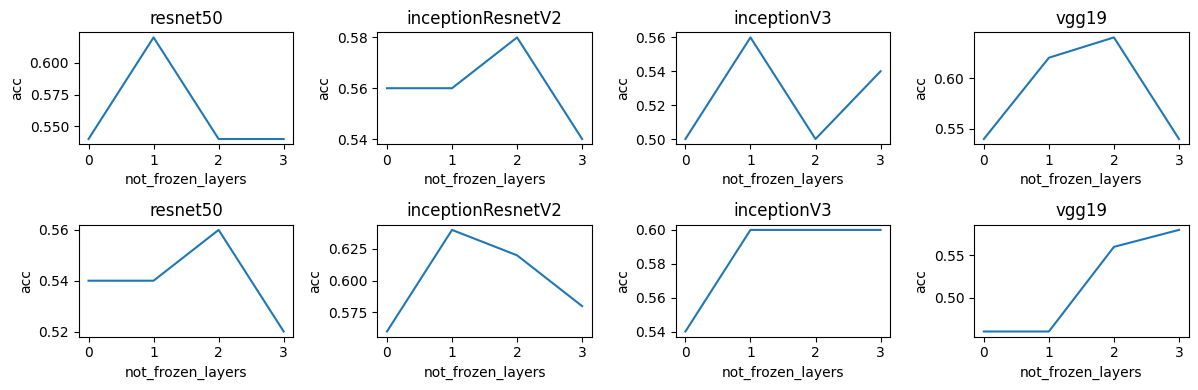

 --------------- TASK  2  ---------------


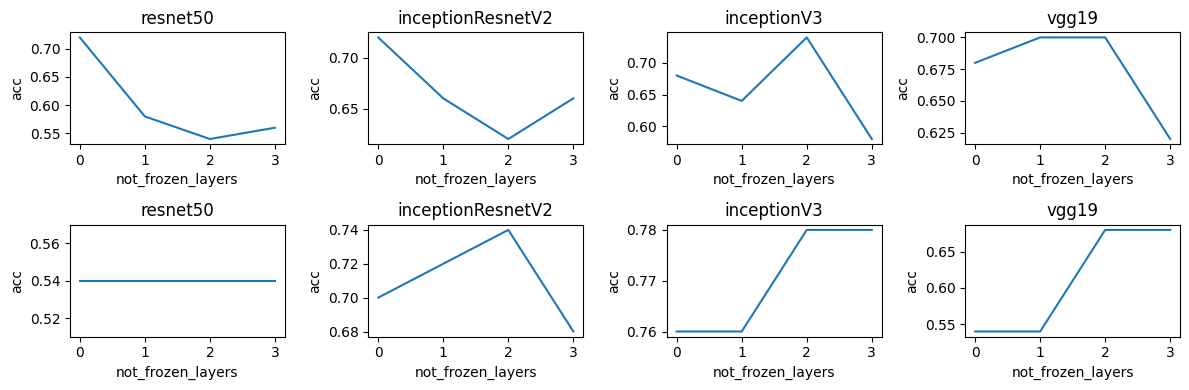

 --------------- TASK  3  ---------------


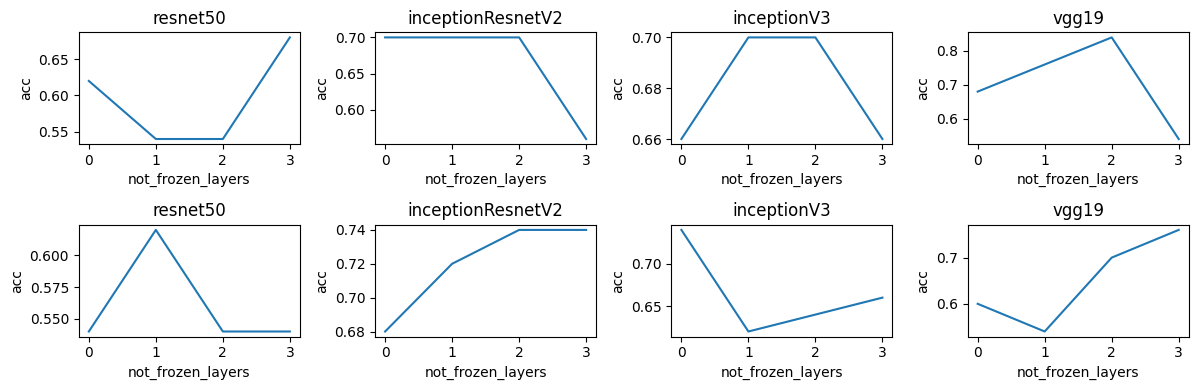

 --------------- TASK  4  ---------------


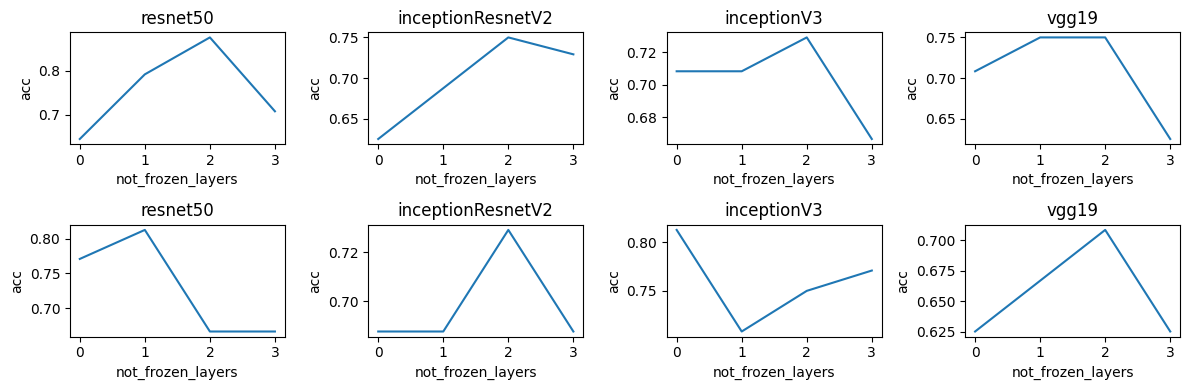

 --------------- TASK  9  ---------------


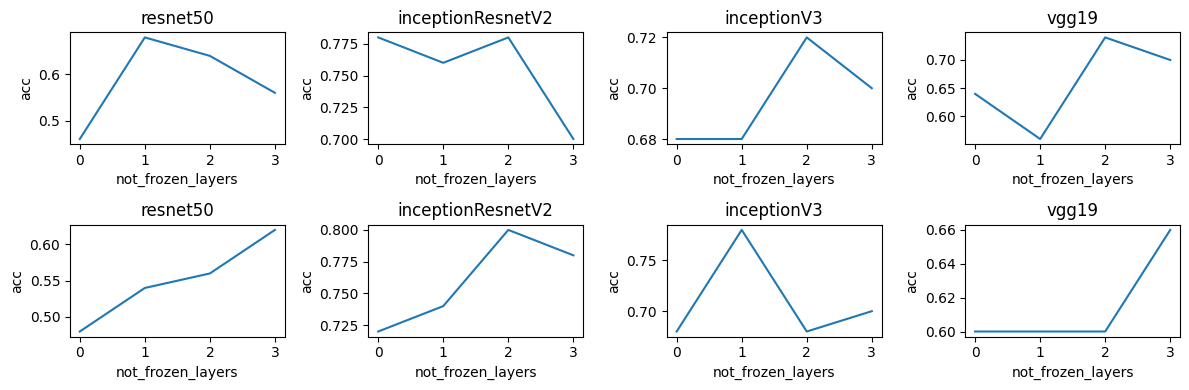

 --------------- TASK  10  ---------------


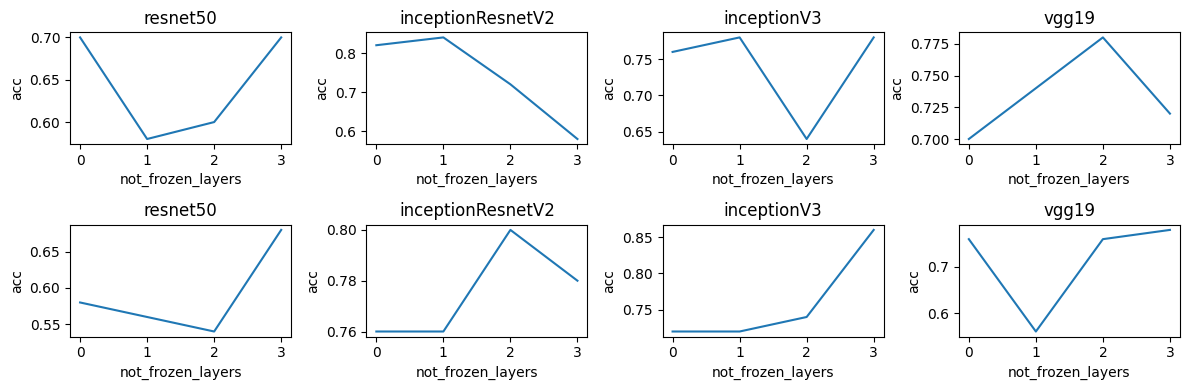

In [85]:
def plot_nfl_vs_metric(metric = "acc"):
    for task_number in tasks_numbers:

        csv_filename = get_results_path(task_number)
        results = pd.read_csv(csv_filename)

        print(" --------------- TASK ", task_number, " ---------------")
        fig, axs = plt.subplots(2, 4, figsize=(12, 4))
        i = 0
        for optimizer_name in ["adam", "paper"]:
            j = 0
            for dnn_name in dnn_names:
                # df_best_models = pd.DataFrame(columns=results.columns)
                filter_model = results[results.iloc[:, 0] == dnn_name]
                filter_model = filter_model[filter_model.iloc[:, 1] == optimizer_name]
                filter_model = filter_model.sort_values(by="not_frozen_layers")

                x_nfl = filter_model['not_frozen_layers']
                y_metric = filter_model[metric]

                axs[i][j].plot(x_nfl, y_metric)
                axs[i][j].set_xlabel('not_frozen_layers')
                axs[i][j].set_ylabel(metric)
                axs[i][j].set_xticks(range(int(x_nfl.min()), int(x_nfl.max())+1))
                axs[i][j].set_title(dnn_name)

                j +=1
            i +=1

        plt.tight_layout()
        plt.show()

plot_nfl_vs_metric()